<a href="https://colab.research.google.com/github/project-ccap/project-ccap.github.io/blob/master/2025notebooks/2025_0611Dell_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dell model の PyTorch 実装 Dell モデル零号機と初号機

- CCAP 資料
- date: 2025_0611
- author: 浅川伸一


In [ ]:
#Colab 上で実行する際には，まず最初に一度だけ，このセルを実行してください
#!pip3 install Cython
#!pip3 install japanize_matplotlib

In [ ]:
import os
import sys
import numpy as np
#import re

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
np.set_printoptions(suppress=False, formatter={'float': '{:6.3f}'.format})
torch.set_printoptions(precision=3)

import matplotlib.pyplot as plt
%matplotlib inline

try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib

In [ ]:
#print('#Dell model の項目間 (ニューロン間) 結合を設定: Ws')
Ws = np.array([[1,1,1,1,1,1,1,1,1,1, 0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0, 0,0,0,0],            # cat 正解
               [0,0,0,0,0,0,0,1,1,1, 1,1,1,1,1,1,1,0,0,0,
                0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0, 0,0,0,0],            # dog 意味エラー
               [0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,1,1,1,
                1,1,1,1,1,1,1,0,0,0, 0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0, 0,0,0,0],            # mat 形態エラー
               [0,0,0,0,0,0,0,1,1,1, 0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,1,1,1, 1,1,1,1,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0, 0,0,0,0],            # rat 混合エラー
               [0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0, 0,0,0,0,1,1,1,1,1,1,
                1,1,1,1,0,0,0,0,0,0, 0,0,0,0],            # fog 無関連エラー
               [0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,1,1,1,1,1,1, 1,1,1,1]             # lat 非単語
              ])

#print('#語彙層と音韻層とを結ぶ結合係数行列の定義: Wp and phonology')
phonology = {'cat': np.array([ 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]),  # correct
             'dog': np.array([ 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]),  # semantic error
             'mat': np.array([ 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0]),  # formal error
             'rat': np.array([ 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]),  # mixed error
             'fog': np.array([ 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]),  # unrelated error
             'lat': np.array([ 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0])}  # nonword
# phonology は BOW 形式なんですなー
Wp = np.array([phonology[item] for item in phonology])

print('#元データ 意味層と語彙層と結合係数 Ws:\n', Ws)
print('#元データ 語彙層と音韻層と結合係数 Wp:\n', Wp)

tags = list(phonology)
print('#相関係数行列 意味入力層<->語彙層 Ws:\n', tags, '\n', np.corrcoef(Ws))
print('#相関係数行列 語彙層<->音韻層 Wp:\n', tags, '\n',
      np.corrcoef(np.array([phonology[item] for item in phonology])))

#Rp = torch.from_numpy(np.corrcoef(Wp)).requires_grad_(False)
#print(Rp)
Rp = torch.Tensor(np.corrcoef(Wp)).requires_grad_(False)
print(Rp)
#Rs = torch.from_numpy(np.corrcoef(Ws)).requires_grad_(False)
#print(Rs)
Rs = torch.Tensor(np.corrcoef(Ws)).requires_grad_(False)
print(Rs)

#元データ 意味層と語彙層と結合係数 Ws:
 [[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
  1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]]
#元データ 語彙層と音韻層と結合係数 Wp:
 [[ 0.000  0.000  0.000  1.000  0.000  1.000  0.000  1.000  0.000]
 [ 0.000  0.000  1.000  0.000  0.000  0.000  1.000  0.000  1.000]
 [ 0.000  0.000  0.000  0.000  1.000  1.000  0.000  1.000  0.000]
 [ 0.000  1.000  0.000  0.000  0.000  1.000  0.000  1.000  0.000]
 [ 1.000 

In [ ]:
def draw_dell_graph(A, B,
                    width_inches=9, height_inches=4, xcolor='green', ycolor='red',
                    alabel='健常統制群データ(Dell,1997)', blabel='beta 調整後のシミュレーション結果',
                    title=None,
                    fontsize=18):
    """Dell モデルのグラフ描画
    A と B 比較対象の２つのモデル出力について，６種類の反応カテゴリの
    棒グラフを描画

    引数:
    A: np.array((6))
    B: np.array((6))
    出力値:
        なし
    """
    fig = plt.figure(figsize=(width_inches,height_inches))
    ax = fig.add_axes([0,0,1,1])
    X = np.arange(B.shape[0])

    ax.bar(X-0.2, A, color=xcolor, width=0.4, label=alabel)
    ax.bar(X+0.2, B, color=ycolor, width=0.4, label=blabel)
    plt.legend(fontsize=fontsize)

    # https://www.javaer101.com/ja/article/5091810.html
    ax.set_xticks(ax.get_xticks().tolist())
    ax.set_ylim(bottom=0, top=1.0)
    ax.set_xticklabels(['', '正解', '意味エラー','形態エラー','混合エラー','無関連エラー', '非単語エラー', ''],fontsize=int(fontsize*0.9))
    if title != None:
        ax.set_title(title)

    plt.show()

#print('Dell model の結果図示')
# plt.title('Dell(1997) Tab. 4 より作成:')
# Dell(1997)による健常者のデータ
#Dells_controls = np.array([0.9690, 0.0120, 0.0010, 0.0090, 0.0030, 0.0000])
Dells_controls = torch.tensor([0.9690, 0.0120, 0.0010, 0.0090, 0.0030, 0.0000])

# Dell(1997)による WD モデルのデータ
#Dells_WD = np.array([0.9660, 0.0210, 0.0000, 0.0120, 0.0000, 0.0010])
Dells_WD = torch.tensor([0.9660, 0.0210, 0.0000, 0.0120, 0.0000, 0.0010])
#draw_dell_graph(Dells_controls, Dells_WD,
#                alabel="Dell(1997)健常者のデータ",
#                blabel="Dell(1997) WD モデル")

# Foygel & Dell(2000)による SP モデルのデータ, Tab. 3 Foygel and Dell (2000)
#Dells_SP = np.array([0.9722, 0.0126, 0.0011, 0.0138, 0.0002, 0.0001])
Dells_SP = torch.tensor([0.9722, 0.0126, 0.0011, 0.0138, 0.0002, 0.0001])
#draw_dell_graph(Dells_controls, Dells_SP,
#                alabel="Dell(1997)健常者のデータ",
#                blabel="Dell(1997) SP モデル")

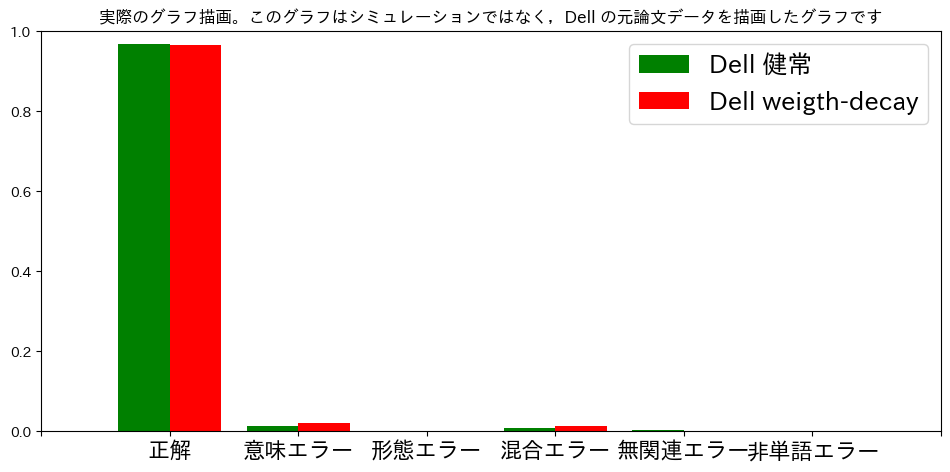

In [ ]:
draw_dell_graph(Dells_controls.detach().numpy(), Dells_WD.detach().numpy(),
               alabel="Dell 健常", blabel='Dell weigth-decay',
               title="実際のグラフ描画。このグラフはシミュレーションではなく，Dell の元論文データを描画したグラフです")

In [ ]:
def my_CrossEntropy(t, p, epsilon=10 ** -7):
    """交差エントロピー"""
    ce = t * torch.log(p) + (1-t) * torch.log(1-t)
    return -ce.sum()

def my_softmax(x, beta=1.):
    """ソフトマックス関数 に温度パラメータを付加したバージョン"""
    if isinstance(x, list):
        x = torch.Tensor(x)
    elif isinstance(x, np.ndarray):
        x = torch.Tensor(x)
    bias = (x * beta).mean()
    return torch.exp(x * beta - bias) / torch.exp(x * beta -bias).sum()

In [ ]:
#初期設定，
#文末 の `.requres_grad(False)` はパラメータの学習，(更新) をしないことを意味する
#これが Dell モデルの特徴である
Sem = torch.zeros(Rs.shape[0]).requires_grad_(False)  #意味層

#意味層の先頭要素に 1 を立てる。すなわち，`cat` 刺激図版が提示されたことを仮定
Sem[0] = 1

Lex = torch.zeros(Rs.shape[0]).requires_grad_(False)  #語彙層
Pho = torch.zeros(Rp.shape[0]).requires_grad_(False)  #音韻層

class Dell_model0(nn.Module):
    """Dell model 零号機"""
    def __init__(self, Rs, Rp):
        super().__init__()
        self.Rs = Rs      #意味層と語彙層との間の結合係数
        self.Rp = Rp      #語彙層と音韻層との間の結合係数
        self.theta_s = nn.Parameter(torch.randn(1))  #Dell の s パラメータ
        self.theta_p = nn.Parameter(torch.randn(1))  #Dell の p パラメータ

        self.sem = torch.zeros(self.Rs.shape[0]).requires_grad_(False)
        self.sem[0] = 1
        self.lex = torch.zeros(self.Rs.shape[0]).requires_grad_(False)
        self.pho = torch.zeros(self.Rp.shape[0]).requires_grad_(False)


        #語彙層のバイアス項 Dell のオリジナルモデルには存在しない
        self.bias_sem = nn.Parameter(torch.zeros(self.Rs.shape[0]))

        #語彙層のバイアス項 Dell のオリジナルモデルには存在しない
        self.bias_lex = nn.Parameter(torch.zeros(self.Rs.shape[0]))

        #音韻層のバイアス項 Dell のオリジナルモデルには存在しない
        self.bias_pho = nn.Parameter(torch.zeros(self.Rp.shape[0]))

        self.beta = nn.Parameter(torch.tensor([1.]))  #ソフトマックス関数の温度パラメータ
        self.a = nn.Tanh()                            #ハイパータンジェント関数を活性化関数として採用

    #def forward(self, inp):
    def forward(self):
        """前向きの処理"""
        self.sem = self.a(self.lex @ (self.Rs * self.theta_s) + self.bias_sem)
        #self.lex = self.a(self.inp @ (self.Rs * self.theta_s) + self.bias_lex)
        self.lex = self.a(self.sem @ (self.Rs * self.theta_s) + self.bias_lex)
        self.pho = self.a(self.lex @ (self.Rp * self.theta_p) + self.bias_pho)
        return my_softmax(self.pho, beta=self.beta)


def train_dell(target, model,
               iter_max=10 ** 3, lr=0.5, loss_f=my_CrossEntropy,
               Rp=Rp, Rs=Rs,
               verbose=False):
    interval = iter_max * 10 ** -1
    model = model(Rs,Rp)                      #モデルの初期化
    for tau in range(iter_max):               #iter_max 回の繰り返し
        #y_hat = model(Sem)                    #入力層へ Sem を与えて，出力値の予測値 y_hat を得る
        y_hat = model()                    #入力層へ Sem を与えて，出力値の予測値 y_hat を得る
        loss = loss_f(target, y_hat)          #直上行で得られた y_hat と予測すべき値 (患者から得れた値など) とから損失値を得る
        #loss.backward()                       #誤差逆伝播を行う
        loss.backward(retain_graph=True)
        with torch.no_grad():
            for param in model.parameters():  #モデルへのフィッティング = 学習
                param -= lr * param.grad
            model.zero_grad()
        if tau % interval == 0 and verbose:       #途中経過の印字
            beta = model.beta.detach().numpy()[0]
            s = model.theta_s.detach().numpy()[0]
            p = model.theta_p.detach().numpy()[0]
            print(f'{tau:05d} loss:{loss:.3f} beta:{1./beta:5.3f} s:{s:5.3f} p:{p:5.3f}')

    #得られた結果の出力
    beta = model.beta.detach().numpy()[0]
    s = model.theta_s.detach().numpy()[0]
    p = model.theta_p.detach().numpy()[0]
    params = {'beta':beta, 's':s, 'p':p}
    return y_hat.detach().numpy(), [beta, s, p]


y_hat, [beta, s, p] = train_dell(Dells_controls, Dell_model0)
print(f'target:{Dells_controls.detach().numpy()}')
print(f'y_hat: {y_hat} beta:{1./beta:.3f} s:{s:.3f} p:{p:.3f}')

y_hat, [beta, s, p] = train_dell(Dells_SP, Dell_model0)
print(f'target:{Dells_SP.detach().numpy()}')
print(f'y_hat: {y_hat} beta:{1./beta:.3f} s:{s:.3f} p:{p:.3f}')

y_hat, [beta, s, p] = train_dell(Dells_WD, Dell_model0)
print(f'target:{Dells_WD.detach().numpy()}')
print(f'y_hat: {y_hat} beta:{1./beta:.3f} s:{s:.3f} p:{p:.3f}')

target:[ 0.969  0.012  0.001  0.009  0.003  0.000]
y_hat: [ 0.975  0.012  0.001  0.009  0.003  0.001] beta:0.251 s:0.695 p:0.731
target:[ 0.972  0.013  0.001  0.014  0.000  0.000]
y_hat: [ 0.972  0.013  0.001  0.014  0.000  0.000] beta:0.239 s:0.186 p:1.112
target:[ 0.966  0.021  0.000  0.012  0.000  0.001]
y_hat: [ 0.966  0.021  0.000  0.012  0.000  0.001] beta:0.230 s:-0.884 p:-0.896


In [ ]:
for teach in [Dells_controls, Dells_SP, Dells_WD]:
    for _ in range(5):
        _teach = teach/teach.sum()
        y_hat, [beta, s, p] = train_dell(_teach, Dell_model0, verbose=False)
        print(f'target:{_teach.detach().numpy()}')
        print(f'y_hat: {y_hat} beta:{1./beta:.3f} s:{s:.3f} p:{p:.3f}')
    print()

target:[ 0.975  0.012  0.001  0.009  0.003  0.000]
y_hat: [ 0.975  0.012  0.001  0.009  0.003  0.001] beta:0.253 s:-1.526 p:0.811
target:[ 0.975  0.012  0.001  0.009  0.003  0.000]
y_hat: [ 0.975  0.012  0.001  0.009  0.003  0.001] beta:0.251 s:-0.986 p:-0.917
target:[ 0.975  0.012  0.001  0.009  0.003  0.000]
y_hat: [ 0.975  0.012  0.001  0.009  0.003  0.001] beta:0.251 s:-1.029 p:-0.505
target:[ 0.975  0.012  0.001  0.009  0.003  0.000]
y_hat: [ 0.975  0.012  0.001  0.009  0.003  0.001] beta:0.256 s:-0.494 p:-1.384
target:[ 0.975  0.012  0.001  0.009  0.003  0.000]
y_hat: [ 0.975  0.012  0.001  0.009  0.003  0.001] beta:0.251 s:0.629 p:0.691

target:[ 0.972  0.013  0.001  0.014  0.000  0.000]
y_hat: [ 0.972  0.012  0.001  0.014  0.000  0.000] beta:0.241 s:-0.716 p:-1.167
target:[ 0.972  0.013  0.001  0.014  0.000  0.000]
y_hat: [ 0.972  0.013  0.001  0.014  0.000  0.000] beta:0.241 s:-1.599 p:-0.942
target:[ 0.972  0.013  0.001  0.014  0.000  0.000]
y_hat: [ 0.247  0.006  0.247  0.24

In [ ]:
print('# Dell モデルの再現実験, 原著論文 Foygell and Dell (2000)を参照のこと')
FoygellDell_tab1={
    #Table 1 のデータ
    0:{'patient':'LH', 'data':[0.69,0.03,0.07,0.15,0.01,0.02]},
    1:{'patient':'IG', 'data':[0.69,0.09,0.05,0.02,0.03,0.01]}
}
print(np.array(FoygellDell_tab1[0]['data']).sum())
print(np.array(FoygellDell_tab1[1]['data']).sum())

In [ ]:
for d in FoygellDell_tab1:
    patient = FoygellDell_tab1[d]['patient']
    teach = FoygellDell_tab1[d]['data']
    teach = np.array(teach)
    teach = teach/teach.sum()
    teach = torch.tensor(teach).requires_grad_(False)
    #teach = torch.tensor(FoygellDell_tab1[d]['data']).requires_grad_(False)
    y_hat, [beta, s, p] = train_dell(teach, Dell_model0)
    print('-' * 73)
    print(f'患者名:{patient}')
    print('                ', list(phonology))
    print('実データ:        ', teach.detach().numpy())
    print(f'target:{teach.detach().numpy()}')
    print(f'y_hat: {y_hat} \nbeta:{1./beta:.3f} s:{s:.3f} p:{p:.3f}')
    draw_dell_graph(teach, y_hat, width_inches=7,height_inches=3, fontsize=14,
                    alabel='患者イニシャル:{0}'.format(patient), blabel='シミュレーション結果',
                    title='Dell モデルの再現実験 (Foygell and Dell,2000)')

In [ ]:
FoygellDell_tab2={
    #Table 2 に記載のデータ。小数点以下４桁目が必要なのか疑問。理由は PNT の検査図版は 175 枚しかない。
    #どんなに努力しても一回の検査で得られるデータは 175 しかないのだから，小数点以下 2 桁で十分ではないかなー
    #各行のデータ，最後の 4 列は weight, decay と s, f パラメータの推定値を表す.
    #ただし s, f は table 4 より引用
    'W.B':  [0.9400,0.0200,0.0100,0.0100,0.0100,0.0000,0.0200,0.5600, 0.0352, 0.0274],
    'T.T.': [0.9300,0.0100,0.0100,0.0000,0.0200,0.0000,0.0200,0.5600, 0.0340, 0.0866],
    'J.Fr.':[0.9200,0.0100,0.0100,0.0200,0.0200,0.0000,0.0200,0.5600, 0.0316, 0.0305],
    'V.C.': [0.8700,0.0200,0.0100,0.0300,0.0100,0.0000,0.0200,0.5700, 0.0407, 0.0229],
    'L.B.': [0.8200,0.0400,0.0200,0.0900,0.0100,0.0100,0.0070,0.5000, 0.0274, 0.0221],
    'J.B.': [0.7600,0.0600,0.0100,0.0500,0.0200,0.0100,0.0065,0.5000, 0.0264, 0.0246],
    'J.L.': [0.7600,0.0300,0.0100,0.0600,0.0300,0.0100,0.0250,0.6000, 0.0255, 0.0221],
    'G.S.': [0.7000,0.0200,0.0600,0.1500,0.0100,0.0200,0.0057,0.5000, 0.0246, 0.0191],
    'L.H.': [0.6900,0.0300,0.0700,0.1500,0.0100,0.0200,0.0057,0.5000, 0.0237, 0.0178],
    'J.G.': [0.5500,0.0600,0.0800,0.1800,0.0400,0.0300,0.0450,0.7000, 0.0191, 0.0172],
    'E.G.': [0.9300,0.0300,0.0000,0.0100,0.0200,0.0000,0.1000,0.6000, 0.0316, 0.0305],
    'B.Me.':[0.8400,0.0300,0.0100,0.0000,0.0500,0.0100,0.1000,0.8200, 0.0165, 0.0866],
    'B.Mi.':[0.8300,0.0500,0.0100,0.0100,0.0200,0.0100,0.0550,0.7000, 0.0255, 0.0328],
    'J.A.': [0.7800,0.0400,0.0000,0.0200,0.0300,0.0100,0.0580,0.7000, 0.0246, 0.0294],
    'A.F.': [0.7500,0.0200,0.0300,0.0700,0.0600,0.0400,0.1000,0.8500, 0.0205, 0.0229],
    'N.C.': [0.7500,0.0300,0.0700,0.0800,0.0100,0.0000,0.1000,0.8500, 0.0237, 0.0221],
    'I.G.': [0.6900,0.0900,0.0500,0.0200,0.0300,0.0100,0.1000,0.8600, 0.0198, 0.0340],
    'H.B.': [0.6100,0.0600,0.1300,0.1800,0.0200,0.0100,0.0500,0.7130, 0.0191, 0.0172],
    'J.F.': [0.5600,0.1400,0.0100,0.0200,0.1100,0.0100,0.1000,0.8600, 0.0107, 0.0365],
    'G.L.': [0.2800,0.0400,0.2100,0.3000,0.0300,0.0900,0.0790,0.8500, 0.0093, 0.0154],
    'W.R.': [0.0800,0.0600,0.1500,0.2800,0.0500,0.3300,0.1000,0.9400, 0.0010, 0.0178]
}

In [ ]:
for patient, teacher in FoygellDell_tab2.items():
    teacher = np.array(teacher[:6])
    teacher = teacher/teacher.sum()
    teacher = torch.tensor(teacher)
    #pred, [beta, s, p] = train_dell(teacher, Dell_model0)

    print('-' * 73)
    print(f'患者名:{patient}')
    #print('                ', list(phonology))
    for _ in range(5):
        pred, [beta, s, p] = train_dell(teacher, Dell_model0)
        print('実データ:        ', teacher.detach().numpy())
        print('シミュレーション: ', pred)
        print(f'ベータ:{1/beta:.3f} s:{s:.3f} p:{p:.3f}')
        # draw_dell_graph(teacher,pred, width_inches=7,height_inches=3, fontsize=14,
        #                 alabel='患者イニシャル:{0}'.format(patient), blabel='シミュレーション結果')

In [ ]:
teacher = torch.tensor(FoygellDell_tab2['J.Fr.'][:6])
patient = 'J.Fr.'
pred, [beta, s, p] = train_dell(teacher, Dell_model0)
print('-' * 73)
print(f'患者名:{patient}')
print('                ', list(phonology))
print('実データ:        ', teacher.detach().numpy())
print('シミュレーション: ', pred)
print(f'ベータ:{1/beta:.3f} s:{s:.3f} p:{p:.3f}')
draw_dell_graph(teacher,pred, width_inches=7,height_inches=3, fontsize=14,
                alabel='患者イニシャル:{0}'.format(patient), blabel='シミュレーション結果')

In [ ]:
# for patient, teacher in FoygellDell_tab2.items():
#     teacher = np.array(teacher[:6])
#     teacher = torch.tensor(teacher)
#     pred, [beta, s, p] = train_dell(teacher, Dell_model0)
#     print('-' * 73)
#     print(f'患者名:{patient}')
#     print('                ', list(phonology))
#     print('実データ:        ', teacher.detach().numpy())
#     print('シミュレーション: ', pred)
#     print(f'ベータ:{1/beta:.3f} s:{s:.3f} p:{p:.3f}')
#     draw_dell_graph(teacher,pred, width_inches=7,height_inches=3, fontsize=14,
#                     alabel='患者イニシャル:{0}'.format(patient), blabel='シミュレーション結果'
#                    )

In [ ]:
print('上図で赤いバーが緑のバーよりも高くなっていることについての考察')
print('特に一番確率の高い反応カテゴリーで，赤いバーが高くなっています。')
print('これは，Dell のオリジナルデータがそもそも足し合わせて １ になっていないからでしょう。')
print('以下に原著論文の表から反応をすべて足し合わせた結果を示します:')

for patient, teacher in FoygellDell_tab2.items():
    teacher = np.array(teacher[:6])
    teacher = np.array(teacher[:6]) / teacher.sum()
    teacher = torch.tensor(teacher)
    pred, [beta, s, p] = train_dell(teacher, Dell_model0)
    print('-' * 73)
    print(f'患者名:{patient}')
    print('                ', list(phonology))
    print('実データ:        ', teacher.detach().numpy())
    print('シミュレーション: ', pred)
    print(f'ベータ:{1/beta:.3f} s:{s:.3f} p:{p:.3f}')
    draw_dell_graph(teacher,pred, width_inches=7,height_inches=3, fontsize=14,
                    alabel='患者イニシャル:{0}'.format(patient), blabel='シミュレーション結果'
                   )

In [ ]:
Daimon2024 = {1: [51, 16, 0, 0, 0, 0, 105],
              2: [166, 37, 0, 1, 0, 2, 3],
              3: [115, 34, 0, 5, 39, 1, 14],
              4: [131, 54, 0, 0, 0, 4, 26],
              5: [126, 18, 0, 0, 54, 0, 10],
              6: [176, 30, 0, 0, 5, 0, 2]
              # 正反応,意味性,音韻性,保続,無反応,無関連,その他
             }
# 上の元データでは音韻性がすべて 0 なので削除してみると
Daimon2024 = {'svPPA': [51,  16, 0,  0, 0, 105],
              'HSVE': [166, 37, 1,  0, 2,  3],
              'SY_IFG': [115, 34, 5, 39, 1, 14],
              'HM_IFG': [131, 54, 0,  0, 4, 26],
              'YT_角回': [126, 18, 0, 54, 0, 10],
              'MR_pMLG': [176, 30, 0,  5, 0,  2]
              # 正反応,意味性,保続,無反応,無関連,その他
             }

# * 正反応  51 166 115 131 126 176
# * 意味性   16  37  34  54  18  30
# * 音韻性    0   0   0   0   0   0
# * 保続      0  1   5   0   0   0
# * 無反応    0  0  39   0  54   5
# * 無関連    0  2   1   4   0   0
# * その他  105  3  14  26  10   2

daimon_results = []

for patient, teacher in Daimon2024.items():
    teacher = np.array(teacher[:6])
    teacher = teacher / teacher.sum()
    #teacher = np.array(teacher[:6]) / teacher.sum()
    teacher = torch.tensor(teacher)
    pred, [beta, s, p] = train_dell(teacher, Dell_model0)
    daimon_results.append({'症例':patient, 'pred':pred, 'teacher':teacher, 'beta':beta, 's':s, 'p':p})
    print('-' * 73)
    print(f'患者名:{patient}')
    print('                ', '正反応,意味性, 保続,無反応,無関連,その他')
    print('実データ:        ', teacher.detach().numpy())
    print('シミュレーション: ', pred)
    print(f'ベータ:{1/beta:.3f} s:{s:.3f} p:{p:.3f}')
    # axes[i][j] = draw_daimon_graph(axes[i][j],
    #                                teacher, pred,
    #                                width_inches=7, height_inches=3, fontsize=14,
    #                                alabel='患者イニシャル:{0}'.format(patient), blabel='シミュレーション結果')


print(daimon_results)

def draw_daimon_graph(ax,
                      A, B,
                      width_inches=9, height_inches=4, xcolor='green', ycolor='red',
                      alabel='TLPAデータ(大門他,2024)', blabel='シミュレーション結果',
                      title=None, fontsize=18,
                     ):
    """大門データ Dell モデルのグラフ描画
    A と B 比較対象の２つのモデル出力について，６種類の反応カテゴリの
    棒グラフを描画

    引数:
    A: np.array((6))
    B: np.array((6))
    出力値:
        なし
    """
    # fig = plt.figure(figsize=(width_inches,height_inches))
    # ax = fig.add_axes([0,0,1,1])

    X = np.arange(B.shape[0])

    ax.bar(X-0.2, A, color=xcolor, width=0.4, label=alabel)
    ax.bar(X+0.2, B, color=ycolor, width=0.4, label=blabel)
    #ax.set_legend(fontsize=fontsize)

    # https://www.javaer101.com/ja/article/5091810.html
    ax.set_xticks(ax.get_xticks().tolist())
    ax.set_ylim(bottom=0, top=1.0)
    #ax.set_xticklabels(['', '正解', '意味エラー','形態エラー','混合エラー','無関連エラー', '非単語エラー', ''],fontsize=int(fontsize*0.9))
    #ax.set_xticklabels(['', '正反応','意味性','音韻性','保続','無反応','無関連','その他'], fontsize=int(fontsize*0.9))

    if title != None:
        ax.set_title(title)

    return ax



# fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8,4))
# i,j = 0, 0

#     j = j+1
#     if j >= 2:
#         j = 0
#         i = i+1

# plt.tight_layout()
# plt.show()

In [ ]:
#print([(d['s'],d['p']) for d in daimon_results)

fig, ax = plt.subplots(figsize=(4,4))
#plt.figure(figsize=(4,4))
for d in daimon_results:
    x, y, beta = d['s'], d['p'], d['beta']
    patient = d['症例']
    ax.scatter(x, y, s=30, c='red')
    ax.annotate(text=f'{patient}({1/beta:.3f})', xy=(x,y), fontsize=12)

#ax.xaxis.set_ticks_position('bottom')
#ax.yaxis.set_ticks_position('left')

# Optional: Add grid for better visualization
ax.grid(True, linestyle='--', alpha=0.6)

# Set labels for clarity
ax.set_xlabel('S')
ax.set_ylabel('P')

plt.savefig('2024Daimon_TLPA_6_4.pdf')
plt.show()


In [ ]:
#help(plt.axis)
#help(ax.xaxis.set_ticks_position)

In [ ]:
Okudaira2012_tab1={
    #
    'W.B':  [0.9400,0.0200,0.0100,0.0100,0.0100,0.0000,0.0200,0.5600, 0.0352, 0.0274],
    'T.T.': [0.9300,0.0100,0.0100,0.0000,0.0200,0.0000,0.0200,0.5600, 0.0340, 0.0866],
    'J.Fr.':[0.9200,0.0100,0.0100,0.0200,0.0200,0.0000,0.0200,0.5600, 0.0316, 0.0305],
    'V.C.': [0.8700,0.0200,0.0100,0.0300,0.0100,0.0000,0.0200,0.5700, 0.0407, 0.0229],
    'L.B.': [0.8200,0.0400,0.0200,0.0900,0.0100,0.0100,0.0070,0.5000, 0.0274, 0.0221],
    'J.B.': [0.7600,0.0600,0.0100,0.0500,0.0200,0.0100,0.0065,0.5000, 0.0264, 0.0246],
    'J.L.': [0.7600,0.0300,0.0100,0.0600,0.0300,0.0100,0.0250,0.6000, 0.0255, 0.0221],
    'G.S.': [0.7000,0.0200,0.0600,0.1500,0.0100,0.0200,0.0057,0.5000, 0.0246, 0.0191],
    'L.H.': [0.6900,0.0300,0.0700,0.1500,0.0100,0.0200,0.0057,0.5000, 0.0237, 0.0178],
    'J.G.': [0.5500,0.0600,0.0800,0.1800,0.0400,0.0300,0.0450,0.7000, 0.0191, 0.0172],
    'E.G.': [0.9300,0.0300,0.0000,0.0100,0.0200,0.0000,0.1000,0.6000, 0.0316, 0.0305],
    'B.Me.':[0.8400,0.0300,0.0100,0.0000,0.0500,0.0100,0.1000,0.8200, 0.0165, 0.0866],
    'B.Mi.':[0.8300,0.0500,0.0100,0.0100,0.0200,0.0100,0.0550,0.7000, 0.0255, 0.0328],
    'J.A.': [0.7800,0.0400,0.0000,0.0200,0.0300,0.0100,0.0580,0.7000, 0.0246, 0.0294],
    'A.F.': [0.7500,0.0200,0.0300,0.0700,0.0600,0.0400,0.1000,0.8500, 0.0205, 0.0229],
    'N.C.': [0.7500,0.0300,0.0700,0.0800,0.0100,0.0000,0.1000,0.8500, 0.0237, 0.0221],
    'I.G.': [0.6900,0.0900,0.0500,0.0200,0.0300,0.0100,0.1000,0.8600, 0.0198, 0.0340],
    'H.B.': [0.6100,0.0600,0.1300,0.1800,0.0200,0.0100,0.0500,0.7130, 0.0191, 0.0172],
    'J.F.': [0.5600,0.1400,0.0100,0.0200,0.1100,0.0100,0.1000,0.8600, 0.0107, 0.0365],
    'G.L.': [0.2800,0.0400,0.2100,0.3000,0.0300,0.0900,0.0790,0.8500, 0.0093, 0.0154],
    'W.R.': [0.0800,0.0600,0.1500,0.2800,0.0500,0.3300,0.1000,0.9400, 0.0010, 0.0178]
}

for patient, teacher in Okudaira2012_tab1.items():
    teacher = np.array(teacher[:6])
    teacher = np.array(teacher[:6]) / teacher.sum()
    teacher = torch.tensor(teacher)
    pred, [beta, s, p] = train_dell(teacher, Dell_model0)
    print('-' * 73)
    print(f'患者名:{patient}')
    print('                ', list(phonology))
    print('実データ:        ', teacher.detach().numpy())
    print('シミュレーション: ', pred)
    print(f'ベータ:{1/beta:.3f} s:{s:.3f} p:{p:.3f}')
    draw_dell_graph(teacher,pred, width_inches=7,height_inches=3, fontsize=14,
                    alabel='患者イニシャル:{0}'.format(patient), blabel='シミュレーション結果'
                   )

In [ ]:
# tags = ['ゴリラ','ヒグマ','コレラ','クジラ']

# import gensim.downloader as api
# m = api.load('word2vec-google-news-300', return_path=True)
# m.most_similar("cat")
# #glove_en = api.load('word2vec-google-news-300', return_path=True)
# #help(glove_en)  #['cat'] #['cat'].shape
# help(api.load)

In [ ]:
# # import gensim.downloader as api
# # glove_en = api.load('word2vec-google-news-300', return_path=True)

# # tags = ['ゴリラ','ヒグマ','コレラ','クジラ']
# # print(len(tags))
# # DellX = np.zeros((len(tags), len(glove_en['cat'])))
# # for i, word in enumerate(tags):
# #     DellX[i] = np.copy(glove_en[word])

# #Dell_wordR = np.corrcoef(DellX)
# #np.savetxt('Dell_wordR.txt',Dell_wordR)
# # Dell の Lexicon 間の相関係数行列。存在しない場合は，このセル上部のコメントをはずして実行

# ccap_stim_dict = {
#     #寺尾先生から教えていただいた刺激語リスト
#     '2morae':{'words':['サル', 'リス', 'ざる', 'サイ'],
#               'R':np.array([[1.   , 0.607, 0.458, 0.504],
#                             [0.607, 1.   , 0.453, 0.449],
#                             [0.458, 0.453, 1.   , 0.677],
#                             [0.504, 0.449, 0.677, 1.   ]],dtype=np.float32)},
#     '3morae':{'words':['ゴリラ', 'ヒグマ', 'コレラ', 'クジラ'],
#               'R':np.array([[1.   , 0.537, 0.46 , 0.572],
#                             [0.537, 1.   , 0.364, 0.58 ],
#                             [0.46 , 0.364, 1.   , 0.561],
#                             [0.572, 0.58 , 0.561, 1.   ]])},
#     '4morae':{'words':['シマウマ', 'トナカイ', 'トラウマ', 'シロクマ'],
#               'R':np.array([[1.   , 0.481, 0.397, 0.534],
#                             [0.481, 1.   , 0.293, 0.352],
#                             [0.397, 0.293, 1.   , 0.36 ],
#                             [0.534, 0.352, 0.36 , 1.   ]])},
#     '5morae':{'words':['オットセイ', 'カンガルー', 'カットソー', 'オポッサム'],
#               'R':np.array([[1.   , 0.402, 0.386, 0.629],
#                             [0.402, 1.   , 0.378, 0.525],
#                             [0.386, 0.378, 1.   , 0.403],
#                             [0.629, 0.525, 0.403, 1.   ]])},
#     '5morae': {'words':['オットセイ', 'カンガルー', 'カットソー', 'ネットカフェ'],
#                'R':np.array([[1.   , 0.402, 0.386, 0.28 ],
#                              [0.402, 1.   , 0.378, 0.281],
#                              [0.386, 0.378, 1.   , 0.265],
#                              [0.28 , 0.281, 0.265, 1.   ]])},
#     #吉原先生のリスト
#     'yoshiharas':{'words': ['ゴリラ','ヒグマ','コレラ','クジラ'],
#                   'R': np.array([[1.00000, 0.43008, 0.06000, 0.42911],
#                                  [0.43008, 1.00000, 0.24685, 0.48078],
#                                  [0.06000, 0.24685, 1.00000, 0.07017],
#                                  [0.42911, 0.48078, 0.07017, 1.00000]])}}

# for morae in ccap_stim_dict:
#     print(morae, end=": ")
#     for x in ccap_stim_dict[morae]:
#         print(ccap_stim_dict[morae][x])

In [ ]:
# !pip3 install Levenshtein
# !pip3 install jaconv

In [ ]:
# print('音韻類似度の近似としてレーベンシュタイン距離を用いる')
# import Levenshtein
# import jaconv
# def levenshtein_distance(a, b):
#     return Levenshtein.distance(a, b)

# l = [jaconv.hira2kata(w) for w in ccap_stim_dict['2morae']['words']]

# def make_phon_R(words):
#     ret = np.zeros((len(l),len(l)))
#     for i, w1 in enumerate(l):
#         for j, w2 in enumerate(l):
#             ret[i][j] = levenshtein_distance(jaconv.hira2kata(w1),jaconv.hira2kata(w2))
#     return ret

# for vocab_set in ccap_stim_dict:
#     word_list = ccap_stim_dict[vocab_set]['words']
#     vocab_set_R = make_phon_R(word_list)
#     print(word_list)
#     print(vocab_set_R)
#     print('最大距離: ', vocab_set_R.max())
#     print(np.ones(vocab_set_R.shape[0]) - vocab_set_R/vocab_set_R.max())
#     print('---')

In [ ]:
class Dell_model1(nn.Module):
    """Dell model 初号機"""
    def __init__(self, Rs, Rp):
        super().__init__()
        if isinstance(Rs, np.ndarray):    #意味層と語彙層との間の結合係数
            self.Rs = torch.from_numpy(Rs.astype(np.float32)).requires_grad_(False)
        if isinstance(Rp, np.ndarray):    #語彙層と音韻層との間の結合係数
            self.Rp = torch.from_numpy(Rp.astype(np.float32)).requires_grad_(False)
        self.theta_s = nn.Parameter(torch.randn(1))  #Dell の s パラメータ
        self.theta_p = nn.Parameter(torch.randn(1))  #Dell の p パラメータ

        self.sem = torch.zeros(self.Rs.shape[0]).requires_grad_(False)
        self.sem[0] = 1
        self.lex = torch.zeros(self.Rs.shape[0]).requires_grad_(False)
        self.pho = torch.zeros(self.Rp.shape[0]).requires_grad_(False)


        #語彙層のバイアス項 Dell のオリジナルモデルには存在しない
        self.bias_sem = nn.Parameter(torch.zeros(self.Rs.shape[0]))

        #語彙層のバイアス項 Dell のオリジナルモデルには存在しない
        self.bias_lex = nn.Parameter(torch.zeros(self.Rs.shape[0]))

        #音韻層のバイアス項 Dell のオリジナルモデルには存在しない
        self.bias_pho = nn.Parameter(torch.zeros(self.Rp.shape[0]))

        self.beta = nn.Parameter(torch.tensor([1.]))  #ソフトマックス関数の温度パラメータ
        self.a = nn.Tanh()                            #ハイパータンジェント関数を活性化関数として採用

    #def forward(self, inp):
    def forward(self):
        """前向きの処理"""
        self.sem = self.a(self.lex @ (self.Rs * self.theta_s) + self.bias_sem)
        #self.lex = self.a(self.inp @ (self.Rs * self.theta_s) + self.bias_lex)
        self.lex = self.a(self.sem @ (self.Rs * self.theta_s) + self.bias_lex)
        self.pho = self.a(self.lex @ (self.Rp * self.theta_p) + self.bias_pho)
        return my_softmax(self.pho, beta=self.beta)


def train_dell1(target, model,
               iter_max=10 ** 3, lr=0.5, loss_f=my_CrossEntropy,
               Rp=Rp, Rs=Rs,
               verbose=False):
    interval = iter_max * 10 ** -1
    model = model(Rs,Rp)                      #モデルの初期化
    for tau in range(iter_max):               #iter_max 回の繰り返し
        #y_hat = model(Sem)                   #入力層へ Sem を与えて，出力値の予測値 y_hat を得る
        y_hat = model()                       #入力層へ Sem を与えて，出力値の予測値 y_hat を得る
        loss = loss_f(target, y_hat)          #直上行で得られた y_hat と予測すべき値 (患者から得れた値など) とから損失値を得る
        #loss.backward()                      #誤差逆伝播を行う
        loss.backward(retain_graph=True)
        with torch.no_grad():
            for param in model.parameters():  #モデルへのフィッティング = 学習
                param -= lr * param.grad
            model.zero_grad()
        if tau % interval == 0 and verbose:       #途中経過の印字
            beta = model.beta.detach().numpy()[0]
            s = model.theta_s.detach().numpy()[0]
            p = model.theta_p.detach().numpy()[0]
            print(f'{tau:05d} loss:{loss:.3f} beta:{1./beta:5.3f} s:{s:5.3f} p:{p:5.3f}')

    #得られた結果の出力
    beta = model.beta.detach().numpy()[0]
    s = model.theta_s.detach().numpy()[0]
    p = model.theta_p.detach().numpy()[0]
    params = {'beta':beta, 's':s, 'p':p}
    return y_hat.detach().numpy(), [beta, s, p]


In [ ]:
stim_words = ccap_stim_dict['2morae']
Rs = ccap_stim_dict['2morae']['R']
Rp = make_phon_R(stim_words)
Rp = np.ones(4) - Rp/Rp.max()
print(stim_words)
print('Rs:\n', Rs)
print('Rp:\n', Rp) #np.ones(4) - Rp/Rp.max())
model = Dell_model1(Rs, Rp)

In [ ]:
#適当な数値を入れて実験
patient_resp = torch.tensor([0.8, 0.1, 0.1, 0.0])
#y_hat, [beta, s, p] = train_dell1(patient_resp, Dell_model1)
y_hat, [beta, s, p] = train_dell1(patient_resp, Dell_model1, Rs=Rs, Rp=Rp)
print(f'target:{patient_resp.detach().numpy()}')
print(f'y_hat: {y_hat} beta:{1./beta:.3f} s:{s:.3f} p:{p:.3f}')


In [ ]:
from ccap import tlpaDataset

In [ ]:
tlpa = tlpaDataset()